# version 02 cgan notebook

In [2]:
import torch
from torch import nn

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os

/Users/emilymiura/opt/anaconda3/envs/dowgan/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## loading data

In [3]:
DATA_FOLDER = "AirQualityUCI"
DATA_FILE = "AirQualityUCI.csv"
path = os.path.join(DATA_FOLDER, DATA_FILE)

# load csv into df
df = pd.read_csv(path, 
                 sep=";", 
                 parse_dates=[['Date', 'Time']],
                 decimal=',')

In [4]:
df.isna().sum()

Date_Time           0
CO(GT)            114
PT08.S1(CO)       114
NMHC(GT)          114
C6H6(GT)          114
PT08.S2(NMHC)     114
NOx(GT)           114
PT08.S3(NOx)      114
NO2(GT)           114
PT08.S4(NO2)      114
PT08.S5(O3)       114
T                 114
RH                114
AH                114
Unnamed: 15      9471
Unnamed: 16      9471
dtype: int64

In [5]:
df = df.iloc[:,0:14]
df = df.dropna(thresh=13)
df.dtypes

Date_Time         object
CO(GT)           float64
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)         float64
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                float64
RH               float64
AH               float64
dtype: object

## visualizing data

In [6]:
def plot_dataframe(dataframe: pd.DataFrame,
                    x: str,
                    y: str,
                    title: str):
    """plots first 100 values from selected x and y columns of AirQuality dataframe"""
    plt.plot(dataframe[x][:100], dataframe[y][:100], label=y)
    plt.xticks(dataframe[x][:100][0::10],
                rotation=45,
                ha='right')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)

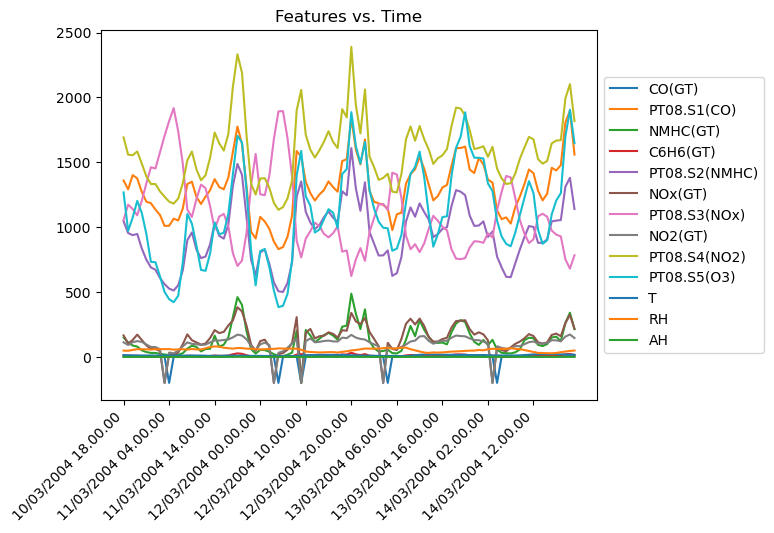

In [7]:
for i, column in enumerate(df.columns[1:]):
    plot_dataframe(dataframe=df,
                   x="Date_Time",
                   y=column,
                   title="Features vs. Time")

Attribute information from Air quality dataset:
* 0 Date (DD/MM/YYYY) / Time (HH.MM.SS) 
* 1 True hourly averaged concentration CO in mg/m^3 (reference analyzer)
* 2 PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)
* 3 True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)
* 4 True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)
* 5 PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)
* 6 True hourly averaged NOx concentration in ppb (reference analyzer)
* 7 PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)
* 8 True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)
* 9 PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)
* 10 PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)
* 11 Temperature in Â°C
* 12 Relative Humidity (%)
* 13 AH Absolute Humidity

I will plan to use this data to predict CO concentration...

## preparing data for dataloader

first i want to convert my df into tensors so i drop the date_time column

In [8]:
# and i want to drop all object columns - including the time column
df = df.drop(columns=['Date_Time'])
df.head(93)

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,2.2,1332.0,129.0,8.6,923.0,144.0,952.0,98.0,1614.0,1225.0,14.5,53.1,0.8728
89,2.8,1445.0,148.0,10.9,1009.0,176.0,878.0,114.0,1696.0,1355.0,16.9,46.1,0.8789
90,2.8,1416.0,145.0,10.7,1002.0,161.0,907.0,119.0,1677.0,1262.0,19.3,38.3,0.8474
91,2.0,1281.0,93.0,7.5,880.0,113.0,1084.0,104.0,1525.0,980.0,21.2,31.4,0.7812


In [9]:
# first i want to convert targets and conditions into tensors

target_tensor = torch.tensor(df['CO(GT)'].values, dtype=torch.float32).reshape(-1,1)
print(f"shape of target_tensor (CO(GT)): {target_tensor.shape}")

conditions_tensor = torch.tensor(df.iloc[:,1:13].values, dtype=torch.float32)
print(f"shape of conditions_tensor: {conditions_tensor.shape}")

shape of target_tensor (CO(GT)): torch.Size([9357, 1])
shape of conditions_tensor: torch.Size([9357, 12])


In [10]:
# from sklearn.preprocessing import MinMaxScaler

# # performing minmax scaler
# scaler = MinMaxScaler(feature_range=(0,3000))
# scaled_conditions = torch.from_numpy(scaler.fit_transform(conditions_tensor))
# print(f'shape of conditions_tensor {conditions_tensor.shape}')
# print(f'range of scaled conditions: {scaled_conditions.min()} - {scaled_conditions.max()}')
# print(f'shape of scaled conditions {scaled_conditions.shape}')

now, i will split the tensor datapoints into equal chunks to create multiple instances of a 'time series example'

In [11]:
9357//100

93

In [12]:
# making a set of 100 samples with each set having approximately 95 data points

N_SAMPLES = 100
N_DATAPOINTS = 93

target_tensor_list = []
conditions_tensor_list = []

for i in np.arange(0, N_SAMPLES-1, 1):
    a = torch.split(target_tensor, N_DATAPOINTS, dim=0)[i]
    target_tensor_list.append(a)
    b = torch.split(conditions_tensor, N_DATAPOINTS, dim=0)[i]
    conditions_tensor_list.append(b)

In [13]:
print(f"length of target: {len(target_tensor_list)}")
print(f"length of conditions: {len(conditions_tensor_list)}")

length of target: 99
length of conditions: 99


In [14]:
conditions_tensor_list[0]

tensor([[1.3600e+03, 1.5000e+02, 1.1900e+01,  ..., 1.3600e+01, 4.8900e+01,
         7.5780e-01],
        [1.2920e+03, 1.1200e+02, 9.4000e+00,  ..., 1.3300e+01, 4.7700e+01,
         7.2550e-01],
        [1.4020e+03, 8.8000e+01, 9.0000e+00,  ..., 1.1900e+01, 5.4000e+01,
         7.5020e-01],
        ...,
        [1.4160e+03, 1.4500e+02, 1.0700e+01,  ..., 1.9300e+01, 3.8300e+01,
         8.4740e-01],
        [1.2810e+03, 9.3000e+01, 7.5000e+00,  ..., 2.1200e+01, 3.1400e+01,
         7.8120e-01],
        [1.2070e+03, 8.4000e+01, 7.5000e+00,  ..., 2.1400e+01, 3.0200e+01,
         7.6160e-01]])

In [15]:
target_tensor_list[98].shape

torch.Size([93, 1])

In [16]:
conditions_tensor_list[98].shape

torch.Size([93, 12])

we want a target tensor of [99, 93, 1] 

we want a condition tensor of [99, 93, 12]

In [17]:
# making a custom dataset class
from torch.utils.data import Dataset, DataLoader

class AirQualityDataset(Dataset):
    def __init__(self, target, conditions):
        self.target = target
        self.conditions = conditions
    def __len__(self):
        return len(self.conditions)
    def __getitem__(self, idx):
        condition = self.conditions[idx]
        target = self.target[idx]
        # sample = {'target': target,
        #           'condition': condition}
        return target, condition

In [18]:
train_data = AirQualityDataset(target=target_tensor_list,
                               conditions=conditions_tensor_list)

In [19]:
target, condition = next(iter(train_data))[0], next(iter(train_data))[1]

In [20]:
print(target.shape)
print(condition.shape)

torch.Size([93, 1])
torch.Size([93, 12])


In [21]:
print(len(train_data[0]))
print(len(train_data))

2
99


## inputting data into dataloader

We will make batch_size = 20, so there are 5 batches of 20 for the 100 samples where each sample contains 93 datapoints of time-series data

In [22]:
from torch.utils.data import DataLoader

BATCH_SIZE = 20

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

In [23]:
print(f"dataloader: {train_dataloader}")
print(f"length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE} samples")
print(f"number of examples: {len(train_data)} \neach example containing target shape (number of timepoint): {train_data[0][0].shape} \nand condition shape: {train_data[0][1].shape}")

dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7fad3432f6a0>
length of train_dataloader: 5 batches of 20 samples
number of examples: 99 
each example containing target shape (number of timepoint): torch.Size([93, 1]) 
and condition shape: torch.Size([93, 12])


In [24]:
targets, conditions = next(iter(train_dataloader))
targets.shape, conditions.shape

(torch.Size([20, 93, 1]), torch.Size([20, 93, 12]))

## building a baseline discriminator model!!

### stepping through nn.Embedding() (discriminator)

In [25]:
# test_condition_3d = conditions[0].unsqueeze(dim=0)
# print(f"shape of the 3d condition tensor, test_condition_3d: {test_condition_3d.shape}")

In [26]:
# # creating a flatten layer
# flatten_model = nn.Flatten()

# # flatten the sample
# test_output = flatten_model(test_condition_3d) # perform forward pass

# # print out what happened
# print(f"shape before flattening: {test_condition_3d.shape}") # -> [color channels, height, width]
# print(f"shape after flattening: {test_output.shape}") 

In [27]:
# print(f"number of unique values of output: {test_output.unique().shape}")
# print(f"max value of output: {test_output.max()}")
# print(f"min value of output: {test_output.min()}")

In [28]:
## performing this scaling step ABOVE - skip this step -
# from sklearn.preprocessing import MinMaxScaler

# # performing minmax scaler 
# scaler = MinMaxScaler(feature_range=(0,3000))
# test_output_scaled = scaler.fit_transform(test_output.reshape(-1,1))
# print(f"the shape of the output scaled: {test_output_scaled.shape}")
# print(f"max value of the test_output_scaled: {test_output_scaled.max()}")
# print(f"min value of the test_output_scaled: {test_output_scaled.min()}")

# # converting to tensor
# test_output_scaled_tensor = torch.from_numpy(test_output_scaled).reshape(1,-1)
# print(f"shape of the test_output_scaled_tensor: {test_output_scaled_tensor.shape}")
# print(f"max value of test_output_scaled_tensor: {test_output_scaled_tensor.max()}")
# print(f"min value of test_output_scaled_tensor: {test_output_scaled_tensor.min()}")

In [29]:
# int(test_output.max())+1

In [30]:
# print(f"original condition shape after flattening and mixmax scaling: {test_output.shape}")

# test_embedding_layer = nn.Embedding(num_embeddings=int(test_output.max())+1,
#                                embedding_dim=100)

# test_conditions_through_embedding = test_embedding_layer(test_output.long())

# print(f"shape after embedding layer: {test_conditions_through_embedding.shape}")

### stepping through nn.Linear after nn.Embedding

In [31]:
# print(f"shape before embedding layer (test_conditions_through_embedding): {test_conditions_through_embedding.shape}")

# test_linear_layer = nn.Linear(in_features=100, # 100 = output shape (not the variable) of embedding layer
#                               out_features=1) # 1 = input_shape of target ?

# test_conditions_through_embedding_linear = test_linear_layer(test_conditions_through_embedding)

# print(f"shape after embedding_linear_layer (test_conditions_through_embedding_linear): {test_conditions_through_embedding_linear.shape}")

### reshaping data using .view()

In [32]:
# test_condition_map = test_conditions_through_embedding_linear.view(93, -1)
# test_condition_map.shape

In [33]:
# test_target = tar gets[0].reshape(-1,1)
# test_target.shape

In [34]:
# test_target_condition_cat = torch.cat([test_target, test_condition_map], dim=1).unsqueeze(dim=0)
# test_target_condition_cat.shape

### stepping through conv1d layer

In [35]:
target, condition = next(iter(train_dataloader))
target.shape, condition.shape

(torch.Size([20, 93, 1]), torch.Size([20, 93, 12]))

In [36]:
condition[0]

tensor([[1.3600e+03, 1.5000e+02, 1.1900e+01,  ..., 1.3600e+01, 4.8900e+01,
         7.5780e-01],
        [1.2920e+03, 1.1200e+02, 9.4000e+00,  ..., 1.3300e+01, 4.7700e+01,
         7.2550e-01],
        [1.4020e+03, 8.8000e+01, 9.0000e+00,  ..., 1.1900e+01, 5.4000e+01,
         7.5020e-01],
        ...,
        [1.4160e+03, 1.4500e+02, 1.0700e+01,  ..., 1.9300e+01, 3.8300e+01,
         8.4740e-01],
        [1.2810e+03, 9.3000e+01, 7.5000e+00,  ..., 2.1200e+01, 3.1400e+01,
         7.8120e-01],
        [1.2070e+03, 8.4000e+01, 7.5000e+00,  ..., 2.1400e+01, 3.0200e+01,
         7.6160e-01]])

In [37]:
target_condition_data = torch.cat([target, condition], axis=2)
target_condition_data.shape

torch.Size([20, 93, 13])

In [38]:
target_condition_data_tranposed = torch.transpose(target_condition_data, 1, 2)
target_condition_data_tranposed.shape

torch.Size([20, 13, 93])

In [39]:
target_condition_data_tranposed[0][1]

tensor([1360., 1292., 1402., 1376., 1272., 1197., 1185., 1136., 1094., 1010.,
        1011., 1066., 1052., 1144., 1333., 1351., 1233., 1179., 1236., 1286.,
        1371., 1310., 1292., 1383., 1581., 1776., 1640., 1313.,  965.,  913.,
        1080., 1044.,  988.,  889.,  831.,  847.,  927., 1091., 1587., 1545.,
        1350., 1263., 1206., 1252., 1287., 1353., 1309., 1274., 1510., 1525.,
        1843., 1598., 1484., 1677., 1280., 1196., 1184., 1172., 1147.,  978.,
        1100., 1112., 1336., 1408., 1447., 1542., 1451., 1328., 1207., 1240.,
        1306., 1326., 1473., 1609., 1611., 1621., 1444., 1418., 1534., 1484.,
        1367., 1344., 1130., 1062., 1076., 1028., 1155., 1235., 1332., 1445.,
        1416., 1281., 1207.])

In [40]:
# initialize cond1d layer

test_conv1 = nn.Conv1d(in_channels=13, # 1 input
                       out_channels=8, # 8 hidden units
                       kernel_size=3,
                       stride=2,
                       padding=1,
                       bias=False)

conv1_output = test_conv1(target_condition_data_tranposed)
conv1_output.shape

torch.Size([20, 8, 47])

## pseudo code for discriminator/generator

In [42]:
# conv => [batch_size, hidden state, 93]
# want to get to [number of examples, probability]
# can use linear layer or max pool+linear layer

```
Disc():
def init (self, target, condition)

self.squential = nn.sequential(
	nn.conv1d/Transpose?(input_size=(# of channels concatenated, 1target+12features("condition")))
	/.../
	nn.conv1d()
	nn.Maxpol()
	nn.Linear(output_size=1)
	nn.Sigmoid()

def forward(self, target, condition):
	x = torch.cat(target, condition)
	x = self.sqeuential(x)


```
Gen():
def init (self, noise, condition)

self.squential = nn.sequential(
	nn.conv1d(input_size=(# of channels concatenated, 1target+12features("condition")))
	/.../
	nn.convTranpose1d()?
	nn.BatchNorm
	nn.Linear(output_size=93)

def forward(self, noise, condition):
	x = torch.cat(noise, condition)
	x = self.sqeuential(x)


### building Discriminator()

In [43]:
conditions.shape

torch.Size([20, 93, 12])

In [35]:
# # initializing embedding layer
# embeddings = nn.Embedding(num_embeddings=int(conditions.max())+1,
#                           embedding_dim=100)
# embeddings.weight.requires_grad = False

In [77]:
# defining a disciminator model

from torch import nn

class Discriminator(nn.Module):
    def __init__(self, embeddings, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        # first manipulate the labels
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)
        #self.condition_embeddings = embeddings

        # pass concatenated target+conditions through nn.Sequential
        self.main = nn.Sequential(
            # input is INPUT SHAPE
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=4,
                      stride=1,
                      padding=0,
                      bias=False),
            nn.LeakyReLU(negative_slope=0.2,
                         inplace=True),
            # state size. 
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=4,
                      stride=1,
                      padding=0,
                      bias=False),
            nn.BatchNorm2d(num_features=hidden_units),
            nn.LeakyReLU(negative_slope=0.2,
                         inplace=True),
            # state size. 
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=4,
                      stride=1,
                      padding=0,
                      bias=False),
            nn.BatchNorm2d(num_features=hidden_units),
            nn.LeakyReLU(negative_slope=0.2,
                         inplace=True),
            # state size. 
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=4,
                      stride=1,
                      padding=0,
                      bias=False),
            nn.BatchNorm2d(num_features=hidden_units),
            nn.LeakyReLU(negative_slope=0.2,
                         inplace=True),
            # state size. 
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=1,
                      kernel_size=4,
                      stride=1,
                      padding=0, bias=False),
            nn.Sigmoid() # output of 
        )

    def forward(self, target, conditions):
        """takes target and conditions"""
        # flattening
        conditions_flattened = self.flatten(conditions.unsqueeze(dim=0))
        print(f"flattened condition shape (dis): {conditions_flattened.shape}")

        # passing through embedding layer
        #conditions = self.condition_embeddings(conditions_flattened.long()).view(BATCH_SIZE, 1, len(target[0]), -1)
        #print(f"conditions shape after embedding (dis): {conditions.shape}")
        
        # forming target to be = [93, 1, 1]
        target = target.unsqueeze(dim=2)
        print(f"target shape after unsqueezing (dis): {target.shape}")
        
        # conditions after embdding = [93, 12, 100]
        # concatenating target+conditions together
        d_in = torch.cat((target, conditions), -1)
        print(f"shape after concat target+conditions (dis): {d_in.shape}")

        # forward pass through nn.Sequential
        out = self.main(d_in)
    
        return out

In [78]:
netD = Discriminator(embeddings=embeddings, input_shape=1, hidden_units=8, output_shape=1)

In [79]:
netD.train()

Discriminator(
  (flatten): Flatten(start_dim=2, end_dim=3)
  (main): Sequential(
    (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(8, 8, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(8, 8, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (6): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(8, 8, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(8, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

#### testing out the discriminator layers with target/conditions input

In [80]:
predictions_d = netD(targets, conditions)
print(f"\nshape of predictions_d of discrimintaor: {predictions_d.shape}")

flattened condition shape (dis): torch.Size([1, 20, 1116])
target shape after unsqueezing (dis): torch.Size([20, 93, 1])
shape after concat target+conditions (dis): torch.Size([20, 93, 13])


RuntimeError: Given groups=1, weight of size [8, 1, 4, 4], expected input[1, 20, 93, 13] to have 1 channels, but got 20 channels instead

In [45]:
# %pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
# from torchviz import make_dot, make_dot_from_trace

# make_dot(predictions_d.mean(), params=dict(netD.named_parameters()), show_attrs=True, show_saved=True)

## building Generator()

### stepping through nn.Embedding() (generator)

In [46]:
# print(f"original condition shape after flattening and mixmax scaling: {test_output.shape}")

# test_embedding_layer_gen = nn.Embedding(num_embeddings=int(test_output.max())+1,
#                                embedding_dim=100)

# test_conditions_through_embedding_gen = test_embedding_layer_gen(test_output.long())

# print(f"shape after embedding layer: {test_conditions_through_embedding_gen.shape}")

### reshaping condition data using .view()

In [47]:
# test_noise = torch.randn(1, 100, 1, 1)
# test_noise.shape

In [48]:
# test_noise_map_gen = test_noise.view(-1, 100)
# test_noise_map_gen.shape

In [49]:
# test_target_cat_gen = torch.cat([test_noise_map_gen, test_conditions_through_embedding_gen], dim=1)
# test_target_cat_gen.shape

In [50]:
# print(f"shape before linear layer (test_conditions_through_embedding): {test_target_cat_gen.shape}")

# test_linear_layer_gen = nn.Linear(in_features=200, 
#                               out_features=1) # input shape of target

# test_conditions_through_embedding_linear_gen = test_linear_layer_gen(test_target_cat_gen)

# print(f"shape after embedding_linear_layer (test_conditions_through_embedding_linear): {test_conditions_through_embedding_linear_gen.shape}")

In [51]:
# test_conditions_through_embedding_linear_gen.unsqueeze(2).unsqueeze(3).shape

In [52]:
# convTranpose_layer_gen = nn.ConvTranspose2d(in_channels=1,
#                                         out_channels=8,
#                                         kernel_size=4,
#                                         stride=1,
#                                         padding=0)
# conv_gen_output = convTranpose_layer_gen(test_conditions_through_embedding_linear_gen.unsqueeze(2).unsqueeze(3))
# conv_gen_output.shape

### building generator()

In [62]:
class Generator(nn.Module):
    def __init__(self, embeddings, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.flatten = nn.Flatten()
        self.condition_embeddings = embeddings

        self.main = nn.Sequential(
            # input is NOISE, going into a convolution
            nn.ConvTranspose2d(in_channels=input_shape,
                               out_channels=hidden_units,
                               kernel_size=4,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(num_features=hidden_units),
            nn.ReLU(True),
            # state size. 
            nn.ConvTranspose2d(in_channels=hidden_units, 
                               out_channels=hidden_units,
                               kernel_size=4,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(num_features=hidden_units),
            nn.ReLU(True),
            # state size. 
            nn.ConvTranspose2d(in_channels=hidden_units, 
                               out_channels=hidden_units, 
                               kernel_size=4,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(num_features=hidden_units),
            nn.ReLU(True),
            # state size.
            nn.ConvTranspose2d(in_channels=hidden_units,
                               out_channels=hidden_units,
                               kernel_size=4,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(num_features=hidden_units),
            nn.ReLU(True),
            # state size.
            nn.ConvTranspose2d(in_channels=hidden_units,
                               out_channels=output_shape,
                               kernel_size=4,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.Tanh()
            # state size. 
        )

    def forward(self, target, conditions):
        """takes target and conditions"""
        # flattening
        conditions_flattened = self.flatten(conditions.unsqueeze(dim=0))
        print(f"flattened condition shape (gen): {conditions_flattened.shape}")

        # passing through embedding layer
        conditions = self.condition_embeddings(conditions_flattened.long()).view(BATCH_SIZE, 1, len(target[0]), -1)
        print(f"conditions shape after embedding (gen): {conditions.shape}")
        
        # forming target to be = [93, 1, 1]
        target = target.unsqueeze(dim=1).unsqueeze(dim=3)
        print(f"target shape after unsqueezing (gen): {target.shape}")
        
        # conditions after embdding = [93, 12, 100]
        # concatenating target+conditions together
        g_in = torch.cat((target, conditions), -1)
        print(f"shape after concat target+conditions (gen): {g_in.shape}")

        # forward pass through nn.Sequential
        out = self.main(g_in)

        return out

In [63]:
noise = torch.randn(BATCH_SIZE, 93)
noise.shape

torch.Size([20, 93])

In [64]:
netG = Generator(embeddings=embeddings, input_shape=1, hidden_units=8, output_shape=1)
netG

Generator(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (condition_embeddings): Embedding(3000, 100)
  (main): Sequential(
    (0): ConvTranspose2d(1, 8, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(8, 8, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 8, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(8, 8, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (10): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (13): Tanh()


#### testing out the generator layers with noise/conditions input

In [65]:
netG.train()
predictions_g = netD(noise, conditions)
print(f"\nshape of predictions_g of generator: {predictions_g.shape}")

flattened condition shape (dis): torch.Size([1, 22320])
conditions shape after embedding (dis): torch.Size([20, 1, 93, 1200])
target shape after unsqueezing (dis): torch.Size([20, 1, 93, 1])
shape after concat target+conditions (dis): torch.Size([20, 1, 93, 1201])

shape of predictions_g of generator: torch.Size([20, 1, 78, 1186])


In [53]:
# make_dot(predictions_g.mean(), params=dict(netG.named_parameters()), show_attrs=True, show_saved=True)

## training and testing loop

In [54]:
# loss_D_list = []
# loss_G_list = []

# epochs = 1

# netD.train()
# netG.train()

# # optimizer for discriminator and generator
# optimizerD = torch.optim.Adam(netD.parameters(),lr=0.0002,betas=(0.5, 0.999))
# optimizerG = torch.optim.Adam(netG.parameters(),lr=0.0002,betas=(0.5, 0.999))

# # number of datapoints in a target
# nz = 93

# real_condition = torch.ones([BATCH_SIZE, len(conditions[0]), len(conditions[0][0])], dtype=torch.float)
# fake_condition = torch.zeros([BATCH_SIZE, len(conditions[0]), len(conditions[0][0])], dtype=torch.float)

# loss_fn = nn.MSELoss()

# #Iterating through epochs
# #for epoch in tqdm(range(epochs)):
# for epoch in range(epochs):

# 	#Iterating through batches (i: iterable int, target: target, condition: condition)
#     for i, (target, condition) in enumerate(train_dataloader):

# 		# initializng fixed noise to generator
#         fixed_noise = torch.randn(BATCH_SIZE, nz)

#         '''
#             Update D network: maximize log(D(x)) + log(1 - D(G(z)))
#         '''
#         #Generating data and feeding it to the discriminator
#         G_result = netG(fixed_noise,condition)
#         print(f"G_result shape: {G_result.shape}")
#         D_fake_result = netD(G_result,condition)
#         print(f"D_rake_result shape: {D_fake_result.shape}")

#         #Inputting real results into discriminator
#         D_real_result = netD(target, condition)

#         #Calculating the loss for the real and the generated data
#         D_real_loss = loss_fn(D_real_result.view(BATCH_SIZE,-1), real_condition)
#         D_fake_loss = loss_fn(D_fake_result.view(BATCH_SIZE,-1), fake_condition)

#         # Back propagation
#         D_train_loss = (D_real_loss + D_fake_loss) / 2
#         loss_D_list.append(D_train_loss)
#         netD.zero_grad()
#         D_train_loss.backward()
#         optimizerD.step()
#         '''
#             Update G network: maximize log(D(G(z)))
#         '''
#         new_condition = torch.LongTensor(BATCH_SIZE,10).random_(0, 10)
#         new_embed = new_condition[:,0].view(-1)
#         G_result = netG(fixed_noise, new_embed)
#         D_fake_result = netD(G_result, new_embed)
#         G_train_loss = loss_fn(D_fake_result.view(BATCH_SIZE,-1), real_condition)
#         loss_G_list.append(G_train_loss)

#         # Back propagation
#         netD.zero_grad()
#         netG.zero_grad()
#         G_train_loss.backward()
#         optimizerG.step()
#         print("D_loss:%f\tG_loss:%f" % (D_train_loss,G_train_loss))